# DA5401 A3: Addressing Class Imbalance with Clustering and Resampling

## Objective: 
This assignment aims to challenge your understanding of class imbalance,
unsupervised learning (clustering), and its application in improving the performance of a
supervised classification model. You will use clustering to create a more representative training
set for both the minority and majority classes through oversampling and undersampling, and
assess the impact on a Logistic Regression classifier.

## Problem Statement
You are working for a fraud detection company. You've been given a highly imbalanced credit
card transaction dataset where a very small fraction of transactions are fraudulent (the minority
class). Standard classification algorithms often perform poorly on such datasets, as they tend to
classify most instances as the majority class to achieve high overall accuracy, ignoring the
minority class.
Your task is to utilize clustering-based oversampling and clustering-based undersampling
to create a more representative and improved training sample. You will then compare the
performance of a Logistic Regression classifier on four different training sets: the original
imbalanced data, data balanced using a naive oversampling method (SMOTE), data balanced
using a clustering-based oversampling approach (CBO), and data balanced using a
clustering-based undersampling approach (CBU).
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible
story that explains your findings. The notebook should be well-commented, reproducible, and
easy to follow.
Dataset: The dataset is available on Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [47]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

### Part A: Data Exploration and Baseline Model

In [2]:
# 1. Load and Analyze the Dataset: Load the creditcard.csv dataset. This dataset has already been pre-processed using PCA, so no feature engineering is required.
credit_card_data = pd.read_csv('creditcard.csv')
print(credit_card_data.head())
print(credit_card_data.info())
print(credit_card_data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

- Based on the above details of the dataset, the dataset has 284,807 rows and 31 columns, all numeric, with no missing values.
- Most feature columns (V1–V28) are standardized and centered around zero, likely from PCA transformation.
- The "Time" column ranges from 0 to ~172,792 seconds, while the "Amount" column is highly skewed, varying from 0 to 25,691.
- The "Class" column is extremely imbalanced, with only about 0.17% fraud cases (1) compared to the majority of legitimate ones (0).

Imbalance Ratio (Non-Fraud:Fraud) = 577.88:1
Class Distribution:
Non-Fraudulent transactions: 284315 (99.8273%)
Fraudulent transactions: 492 (0.1727%)


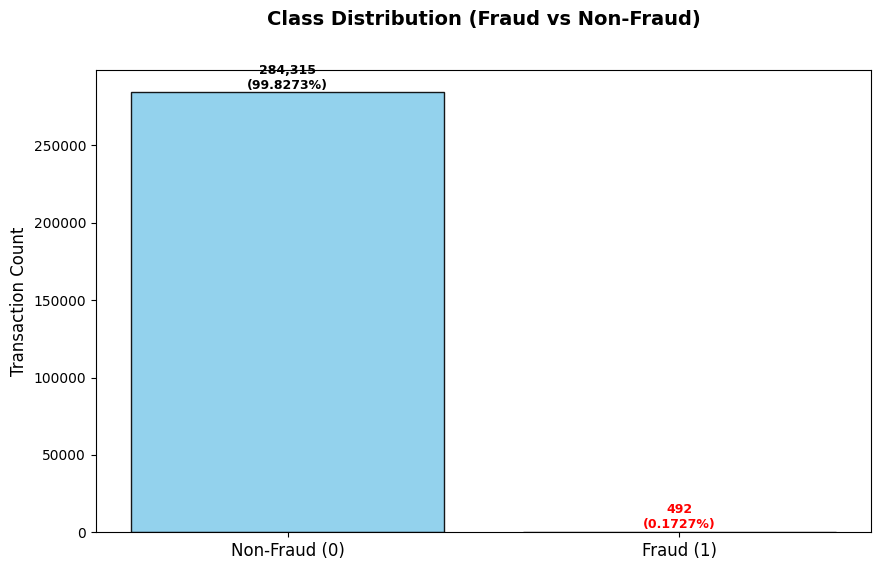

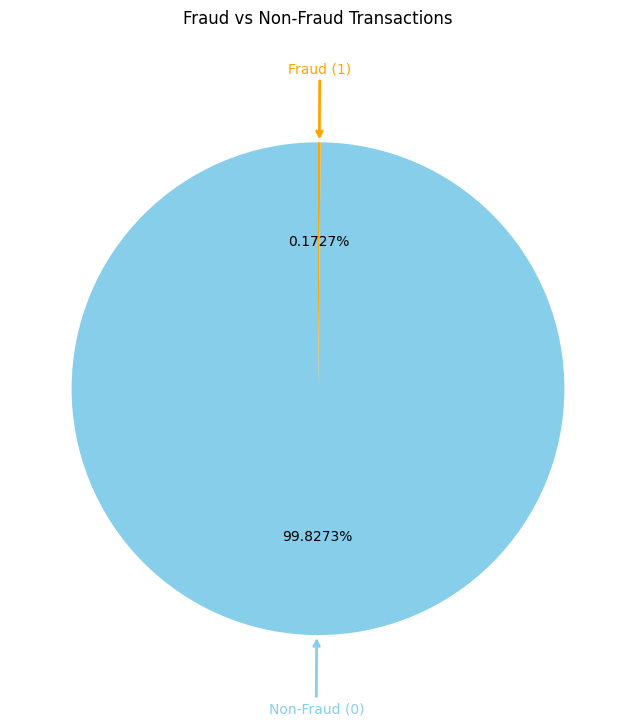

In [38]:
# 2. Analyze Class Distribution: Print the class distribution (count of fraudulent vs non-fraudulent transactions). A pie chart or bar plot would be a good visualization. Clearly state the degree of imbalance.

class_counts = credit_card_data['Class'].value_counts()
non_fraud = class_counts[0]
fraud = class_counts[1]
imbalance_ratio = non_fraud / fraud
labels = ['Non-Fraud (0)', 'Fraud (1)']
bar_colors = ['skyblue', 'red']
pie_colors = ['skyblue', 'orange']
total = len(credit_card_data)

print(f'Imbalance Ratio (Non-Fraud:Fraud) = {imbalance_ratio:.2f}:1')
print("Class Distribution:")
print(f"Non-Fraudulent transactions: {non_fraud} ({non_fraud/total*100:.4f}%)")
print(f"Fraudulent transactions: {fraud} ({fraud/total*100:.4f}%)")

plt.figure(figsize=(10,6))
bars = plt.bar(class_counts.index, class_counts.values, 
               color=bar_colors, edgecolor='black', alpha=0.9)

plt.xticks(ticks=[0,1], labels=labels, fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.title("Class Distribution (Fraud vs Non-Fraud)", 
          fontsize=14, fontweight='bold', y=1.08)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height/total)*100
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + total*0.001,
             f"{height:,}\n({pct:.4f}%)",
             ha='center', va='bottom', fontsize=9,
             color='black' if i==0 else 'red', fontweight='bold')

plt.show()


plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    class_counts,
    autopct='%1.4f%%',
    startangle=90,
    colors=pie_colors
)

# Add labels with arrows dynamically
for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 + wedge.theta1)/2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    plt.annotate(labels[i],
                 xy=(x, y), xytext=(1.3*x, 1.3*y),
                 arrowprops=dict(arrowstyle="->", 
                                 color=pie_colors[i], lw=2),
                 ha='center', va='center',
                 fontsize=10, color=pie_colors[i])

plt.title("Fraud vs Non-Fraud Transactions", y=1.08)
plt.show()

Class distribution in full dataset:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Class distribution in training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Class distribution in testing set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9997    0.9996     56864
           1     0.8193    0.6939    0.7514        98

    accuracy                         0.9992     56962
   macro avg     0.9094    0.8468    0.8755     56962
weighted avg     0.9992    0.9992    0.9992     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


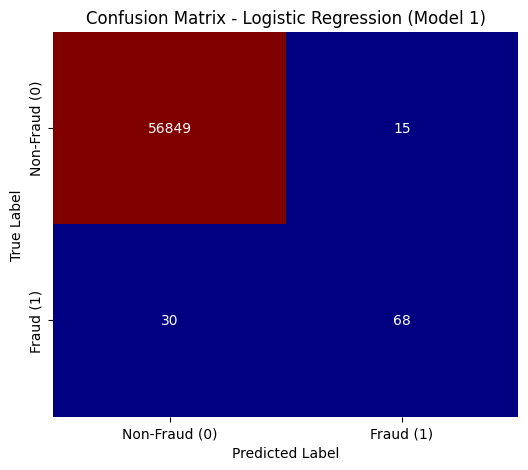

In [ ]:
# 3 Baseline Model:

# Split the original dataset into training and testing sets. Crucially, ensure the test set retains its original imbalance.
X = credit_card_data.drop('Class', axis=1)
y = credit_card_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,   # 20% for testing
    random_state=42, # reproducibility
    stratify=y       # crucial for keeping imbalance ratio
)
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

#Train a Logistic Regression classifier on the imbalanced training data. This will be your Model 1

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

#Evaluate the model's performance on the test set. Pay close attention to metrics robust to imbalance, such as Precision, Recall, and the F1-score for the minority (fraudulent) class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="jet", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])

plt.title("Confusion Matrix - Logistic Regression (Model 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

- Explain why accuracy is a misleading metric in this scenario.
    - Accuracy is a misleading metric in this scenario, mainly because of the class imbalance. The model could predict everything as "Non-Fraud" and still achieve ~99.8% accuracy without catching a single fraud.
    - Accuracy = (TP + TN) / Total. With so many true negatives, accuracy looks high. Even then from the above results, we could see that the model has miss classified 30 fraud cases.
    - In fraud detection, the cost of missing a fraud (False Negative) is much higher than the cost of flagging a non-fraud incorrectly (False Positive). Accuracy doesn’t differentiate between these costs — it treats every error equally.

### Part B: Resampling Approaches

In [45]:
#1. Naive Oversampling (SMOTE):

#Apply the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to the training data. This method generates synthetic samples for the minority class.

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution in training set (before SMOTE):")
print(y_train.value_counts())

print("\nClass distribution in training set (after SMOTE):")
print(y_train_smote.value_counts())

Class distribution in training set (before SMOTE):
Class
0    227451
1       394
Name: count, dtype: int64

Class distribution in training set (after SMOTE):
Class
0    227451
1    227451
Name: count, dtype: int64


- Explain how SMOTE works and its potential limitations, such as generating noisy samples if the minority class is not well-defined.
    - SMOTE (Synthetic Minority Over-sampling Technique) balances a dataset by creating new, synthetic samples for the minority class instead of just duplicating existing ones.
        - Pick a minority sample, example: Fraud transaction in our case
        - Find it's K-Nearest neighbors (default k value is 5) within the minority class
        - Randomly select one the neighbors
        - Generate a synthetic sample along the line segment between the original sample and it's neighbor
        - xnew ​= xi​+δ×(xnn​−xi​),∼U(0,1), where xi = original minority sample, xnn = one of it's nearest neighbor, δ = random number between 0 to 1

    - Potential limitations:
        - If the minority class is not well-defined (overlaps heavily with majority class), SMOTE may generate synthetic points inside majority regions, leading to confusing/noisy data.
        - In high-dimensional data, “nearest neighbors” might not be meaningful, and SMOTE can generate unrealistic samples.
        - If the minority class itself is very small or noisy, the model may overfit to those synthetic points.
        - SMOTE assumes minority data is spread uniformly. But in reality, fraud (minority) may consist of different subgroups (e.g., online fraud vs. ATM fraud). SMOTE might generate artificial samples that don’t reflect real-world fraud patterns.
        - Nearest-neighbor searches can be slow on large datasets.

2 Clustering-Based Oversampling:

- Explain the concept of using clustering for oversampling to ensure diversity and explain how it achieves this goal.
    - Problem with naive oversampling:
        - Just duplicates samples → risk of overfitting.
        - Synthetic points may cluster in already dense regions → poor diversity.
    - Clustering-based approach:
        - Cluster the minority class samples (e.g., k-means, DBSCAN).
        - Identify sparse vs. dense regions of the minority class.
        - Generate synthetic samples within clusters, often allocating more to sparse clusters.
    - How it ensures diversity:
        - Distributes new samples across different clusters (subregions).
        - Covers all natural subgroups of the minority class.
        - Avoids concentrating synthetic data in one dense area.
        - Preserves intra-class variance → captures more patterns.
    - Outcome:
        - More diverse and representative minority samples.
        - Better decision boundary coverage.
        - Reduced risk of overfitting and improved generalization.

In [ ]:
# Extract minority and majority classes
X_train_minority = X_train[y_train == 1].copy()
X_train_majority = X_train[y_train == 0].copy()

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

# ---- Step 1: KMeans clustering on minority class ----
k = 3  # can tune using elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_train_minority)

X_train_minority["cluster"] = clusters

# ---- Step 2: Oversample within clusters ----
synthetic_samples = []

for c in range(k):
    cluster_samples = X_train_minority[X_train_minority["cluster"] == c].drop("cluster", axis=1).values
    n_samples = len(cluster_samples)

    if n_samples > 1:  # at least 2 points to interpolate
        # Decide how many synthetic points to generate (example: double each cluster)
        n_to_generate = n_samples  # can scale this as needed
        for _ in range(n_to_generate):
            # pick two random points inside the cluster
            i, j = np.random.choice(n_samples, 2, replace=False)
            lam = np.random.rand()  # random weight
            new_point = lam * cluster_samples[i] + (1 - lam) * cluster_samples[j]
            synthetic_samples.append(new_point)

# Convert to array
X_synthetic = np.array(synthetic_samples)
y_synthetic = np.ones(len(X_synthetic))  # all frauds

# ---- Step 3: Combine with original training set ----
X_train_balanced = np.vstack([X_train.values, X_synthetic])
y_train_balanced = np.hstack([y_train.values, y_synthetic])

print(f"Original training size: {len(X_train)}")
print(f"Synthetic samples created: {len(X_synthetic)}")
print(f"Final balanced training size: {len(X_train_balanced)}")

Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Original training size: 227845
Synthetic samples created: 394
Final balanced training size: 228239


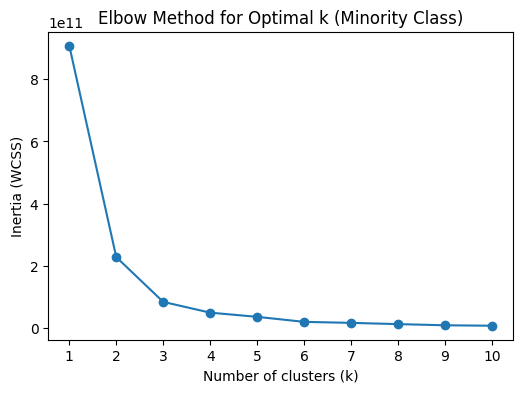

In [52]:
X_train_minority = X_train[y_train == 1]

# Range of k values to test
k_values = range(1, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_minority)
    inertias.append(kmeans.inertia_)  # sum of squared distances to cluster centers

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal k (Minority Class)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.show()

In [ ]:
X_train_minority = X_train[y_train == 1].copy()
X_train_majority = X_train[y_train == 0].copy()

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

# ---- Step 1: KMeans clustering on minority class ----
k = 4  # can tune using elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_train_minority)

X_train_minority["cluster"] = clusters

# ---- Step 2: Oversample within clusters ----
synthetic_samples = []

for c in range(k):
    cluster_samples = X_train_minority[X_train_minority["cluster"] == c].drop("cluster", axis=1).values
    n_samples = len(cluster_samples)

    if n_samples > 1:  # at least 2 points to interpolate
        # Decide how many synthetic points to generate (example: double each cluster)
        n_to_generate = n_samples  # can scale this as needed
        for _ in range(n_to_generate):
            # pick two random points inside the cluster
            i, j = np.random.choice(n_samples, 2, replace=False)
            lam = np.random.rand()  # random weight
            new_point = lam * cluster_samples[i] + (1 - lam) * cluster_samples[j]
            synthetic_samples.append(new_point)

# Convert to array
X_synthetic = np.array(synthetic_samples)
y_synthetic = np.ones(len(X_synthetic))  # all frauds

# ---- Step 3: Combine with original training set ----
X_train_balanced = np.vstack([X_train.values, X_synthetic])
y_train_balanced = np.hstack([y_train.values, y_synthetic])

print(f"Original training size: {len(X_train)}")
print(f"Synthetic samples created: {len(X_synthetic)}")
print(f"Final balanced training size: {len(X_train_balanced)}")

Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Original training size: 227845
Synthetic samples created: 394
Final balanced training size: 228239


In [56]:
# Oversample from each minority cluster to create a new, balanced dataset. The goal is to ensure that all sub-groups are well-represented, thereby avoiding the creation of synthetic samples in regions with no actual data.
X_train_minority = X_train[y_train == 1].copy()
X_train_majority = X_train[y_train == 0].copy()

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

# ---- Step 1: KMeans clustering on minority class ----
k = 3  # can be chosen using elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_train_minority)

X_train_minority["cluster"] = clusters

# ---- Step 2: Decide how many samples to generate per cluster ----
total_minority = len(X_train_minority)
total_majority = len(X_train_majority)
target_minority = total_majority  # balance both classes

needed = target_minority - total_minority
print(f"Need to generate {needed} synthetic fraud samples.")

# Allocate new samples proportional to cluster size
cluster_counts = X_train_minority["cluster"].value_counts().to_dict()
cluster_allocations = {
    c: int(needed * (count / total_minority))
    for c, count in cluster_counts.items()
}

# ---- Step 3: Generate synthetic samples inside each cluster ----
synthetic_samples = []

for c, n_to_generate in cluster_allocations.items():
    cluster_samples = X_train_minority[X_train_minority["cluster"] == c].drop("cluster", axis=1).values
    n_samples = len(cluster_samples)

    if n_samples > 1 and n_to_generate > 0:
        for _ in range(n_to_generate):
            # Pick two random points from the cluster
            i, j = np.random.choice(n_samples, 2, replace=False)
            lam = np.random.rand()  # interpolation factor
            new_point = lam * cluster_samples[i] + (1 - lam) * cluster_samples[j]
            synthetic_samples.append(new_point)

# Convert synthetic samples into arrays
X_synthetic = np.array(synthetic_samples)
y_synthetic = np.ones(len(X_synthetic))  # all frauds

# ---- Step 4: Combine with original training set ----
X_train_balanced = np.vstack([X_train.drop(columns=[], errors="ignore").values, X_synthetic])
y_train_balanced = np.hstack([y_train.values, y_synthetic])

print(f"Final balanced training size: {len(X_train_balanced)}")
print(f"  Non-Fraud: {np.sum(y_train_balanced==0)}")
print(f"  Fraud: {np.sum(y_train_balanced==1)}")


Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Need to generate 227057 synthetic fraud samples.
Final balanced training size: 454900
  Non-Fraud: 227451
  Fraud: 227449
